<h1 style="text-align: center;">Risques extrêmes en finance de marché</h1>


### Introduction

La modélisation du risque de marché extrême est un domaine crucial pour évaluer les événements rares, mais potentiellement catastrophiques, qui peuvent affecter les marchés financiers. 

Les méthodes traditionnelles de simulation, telles que le Monte Carlo naïf, sont couramment utilisées pour estimer la distribution des pertes et des gains. Cependant, bien que cette approche soit utile pour simuler un large éventail de scénarios, elle présente des limitations importantes lorsqu'il s'agit de capturer correctement les événements rares. 

En effet, le Monte Carlo naïf ne permet pas de visualiser efficacement les probabilités associées à ces événements extrêmes, car les simulations ne sont pas suffisamment nombreuses pour refléter fidèlement la faible probabilité de tels événements. 

Par conséquent, une approche plus sophistiquée est nécessaire pour modéliser avec précision le risque de marché extrême et fournir des évaluations fiables des risques associés à des événements peu fréquents mais potentiellement dévastateurs.




In [1]:
#modules importation
import numpy as np
import scipy.stats as sps 
import matplotlib.pyplot as plt
import math as m
import seaborn as sns


### 1 – Modélisation du portefeuille


In [2]:
#Benchmark values
S_0=100
K=100
var=2
sigma = np.sqrt(var)
vars=[2 for i in range(10)]
S_s=[100 for i in range(10)]
alpha=np.array([10 for i in range(10)])
beta=np.array([5 for i in range(10)])

On supposera que le cours d’action est modélisé par un mouvement brownien géométrique :

$$
S_t = S_0 e^{-\frac{1}{2} \sigma^2 t + \sigma W_t}
$$

En particulier, $S_t$ est solution de l’équation différentielle stochastique (1) :

$$
dS_t = \sigma S_t dW_t
$$

de prix initial $S_0$. Précisons les notations :

- $W = (W_t)_{t \geq 0} $ est un mouvement brownien, c’est-à-dire un processus continu à temps continu, avec $W_0 = 0$, des accroissements indépendants et stationnaires, dont les accroissements $W_{t+h} - W_t$ suivent une loi gaussienne $N(0, h)$.

Le rendement de S (variation relative) sur un court intervalle de temps $h \ll 1$ peut s’écrire :

$$
\frac{S_{t+h} - S_t}{S_t} \approx \sigma (W_{t+h} - W_t)
$$

Ainsi, $\sigma^2$ mesure la variance des rendements instantanés (appelée aussi volatilité).


In [3]:
def Brownian_motion(t,h=0.1,n_paths=1000):
    '''Cette fonction génère plusieurs simulations de mouvement Brownien
    args:
    - t: l'instant de fin de la simulation
    - h: pas de discrétisation
    - n_paths: nombre de simulations
    returns:
    - n_paths simulations de mouvement Brownien jusqu'à l'instant t'''
    
    n_steps=int(t/h)
    dW=np.random.normal(0, np.sqrt(h/365), size=(n_paths, n_steps))
    result=np.zeros((n_paths, n_steps+1))
    result[:,1:]=np.cumsum(dW, axis=1)
    return result
    

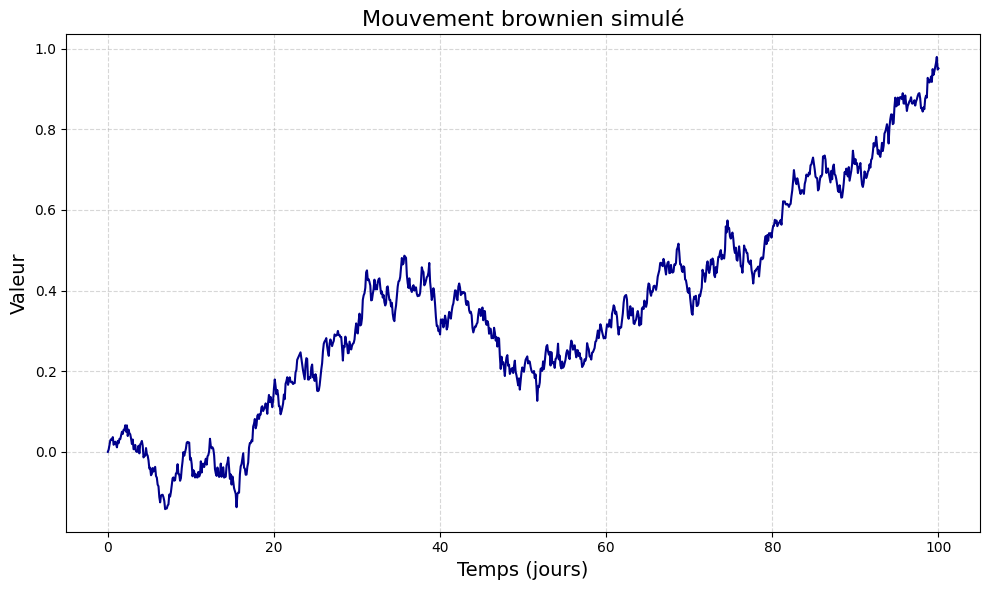

In [4]:
Brownian=Brownian_motion(100)
time=np.linspace(0,100,1001)
plt.figure(figsize=(10, 6))
sns.lineplot(x=time, y=Brownian[0], color='darkblue')
plt.title("Mouvement brownien simulé", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Valeur", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [5]:
def Stock_price(S,var,Brownian,h=0.001):
    '''Cette fonction génère plusieurs simulations de prix d'action
    args:
    - S: prix initial de l'action
    - var: volatilité de l'action
    - Brownian: plusieurs simulation de mouvement Brownien
    - h: pas de discrétisation
    returns:
    - plusieurs simulations de prix d'action jusqu'à un instant donné'''
    
    n_paths,n_steps = Brownian.shape
    times=np.arange(n_steps) * h / 365
    drift=(-0.5 * var**2)*times
    diffusion =var*Brownian
    log_S=drift + diffusion
    S=S * np.exp(log_S)
    return S
    

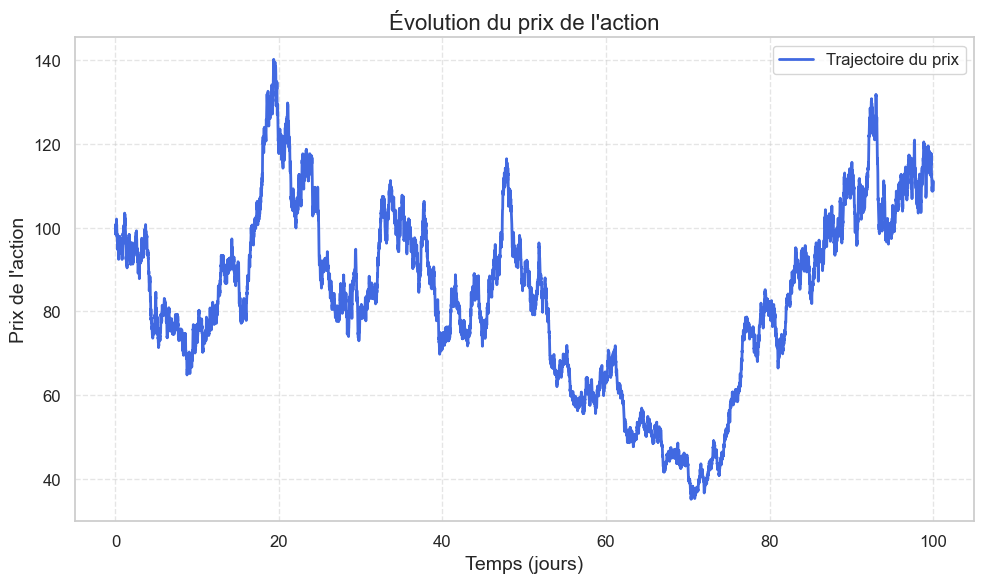

In [6]:
Brownian=Brownian_motion(100,0.01)
Stock=Stock_price(S_0,var,Brownian)
time=np.linspace(0,100,10001)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time, Stock[0], color='royalblue', linewidth=2, label='Trajectoire du prix')

plt.title("Évolution du prix de l'action", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Prix de l'action", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Dans ce modèle négligeant les taux d’intérêt, le prix $Call(t, S_t)$ de l’option d’achat à la date t avant maturité T, lorsque le sous-jacent vaut $S_t$, est donné par la formule de Black & Scholes :

$$
Call(t, S_t) = S_t N[d^+((T - t), S_t, K)] - K N[d^-((T - t), S_t, K)]
$$

avec

$$
d^\pm(\tau, x, y) = \frac{1}{\sigma \sqrt{\tau}} \left( \ln\left(\frac{x}{y}\right) \pm \sigma \sqrt{\tau} \right)
$$

où $N$ est la fonction de répartition de la loi normale centrée réduite.

Le prix $Put(t, S_t)$ du Put a une forme symétrique :

$$
Put(t, S_t) = K N[d^+((T - t), K, S_t)] - S_t N[d^-((T - t), K, S_t)].
$$


In [7]:
def Call_price(var,K,T,Stock,h=0.01):
    '''Cette fonction génère plusieurs simulations de prix du Call
    args:
    - Stock: plusieurs simulations de prix de l'action
    - var: volatilité de l'action
    - K: prix de l'exercice de l'option
    - T: maturité de l'option
    - h: pas de discrétisation
    returns:
    - plusieurs simulations de prix du Call jusqu'à un instant donné'''
    
    n_steps=Stock.shape[1]
    times=np.arange(n_steps)*h
    sqrt_tau=np.sqrt((T-times)/365)
    d_p=1/(var*sqrt_tau)*np.log(Stock/K)+0.5*var*sqrt_tau
    d_n=1/(var*sqrt_tau)*np.log(Stock/K)-0.5*var*sqrt_tau
    normal_p=sps.norm.cdf(d_p,0,1)
    normal_n=sps.norm.cdf(d_n,0,1)
    result=Stock*normal_p-K*normal_n
    return result

def Put_price(var,K,T,Stock,h=0.01):
    '''Cette fonction génère plusieurs simulations de prix du Put
    args:
    - Stock: plusieurs simulations de prix de l'action
    - var: volatilité de l'action
    - K: prix de l'exercice de l'option
    - T: maturité de l'option
    - h: pas de discrétisation
    returns:
    - plusieurs simulations de prix du Put jusqu'à un instant donné'''
    n_steps=Stock.shape[1]
    times=np.arange(n_steps)*h
    sqrt_tau=np.sqrt((T-times)/365)
    d_p=1/(var*sqrt_tau)*np.log(Stock/K)+0.5*var*sqrt_tau
    d_n=1/(var*sqrt_tau)*np.log(Stock/K)-0.5*var*sqrt_tau
    normal_p=sps.norm.cdf(d_p,0,1)
    normal_n=sps.norm.cdf(d_n,0,1)
    result=K*normal_p-Stock*normal_n
    return result

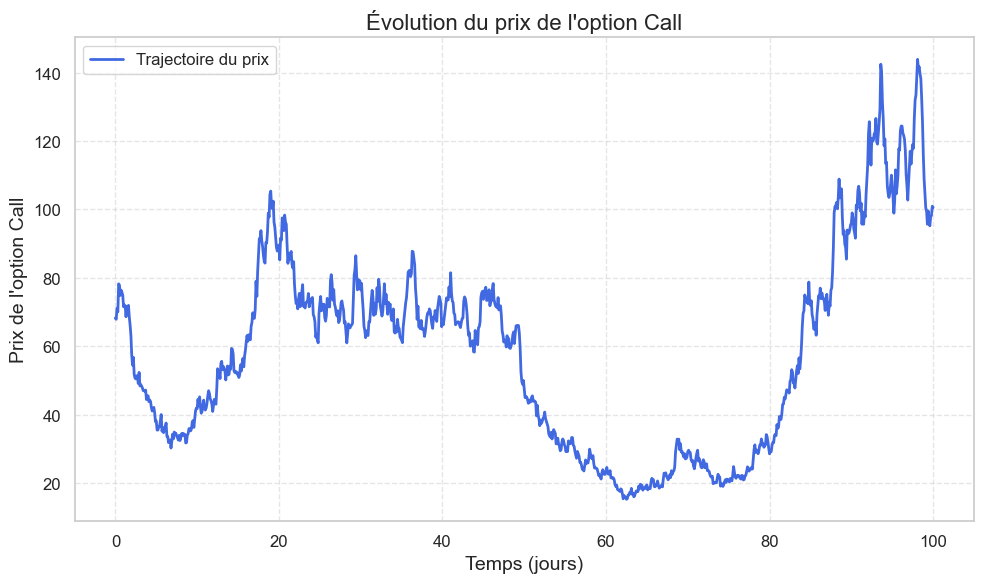

In [8]:
Brownian=Brownian_motion(100,0.1)
Stock=Stock_price(S_0,var,Brownian)
Calls=Call_price(var,K,365,Stock)
time=np.linspace(0,100,1001)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time,Calls[0], color='royalblue', linewidth=2, label='Trajectoire du prix')

plt.title("Évolution du prix de l'option Call", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Prix de l'option Call", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

On considère un portefeuille combinant des calls/puts sur \( I_0 \) actions différentes. La valeur \( V_t \) du portefeuille est donc donnée par :

$$
V_t = \sum_{i=1}^{I_0} \left( \alpha_i \text{Call}_i(t, S_i^t) + \beta_i \text{Put}_i(t, S_i^t) \right)
$$

avec $(S_t^i)_{t \geq 0}$ étant la solution de l'équation (1), étant donné un mouvement brownien $(W_i)_{t \geq 0}$ et un écart-type des rendements $\sigma_i$, et $\alpha_i, \beta_i \in \mathbb{R}$, $i \in \{1, \dots, I_0\}$.

In [9]:
def Portfolio_Value(alpha,beta,t,T,S,K,vars,h=0.01,n_paths=1000):
    '''Cette fonction génère plusieurs simulations de la valeur du portefeuille
    args:
    - alpha: part des options Call
    - beta: part des options Put
    - t: l'instant de fin de la simulation
    - K: prix de l'exercice des options
    - T: maturité des options
    - S: prix initiaux des actions
    - vars: volatilité des actions
    - h: pas de discrétisation
    - n_paths: nombre des simulations
    returns:
    - plusieurs simulations de la valeur du portefeuille jusqu'à un instant donné'''
    
    n_stocks=len(S)
    Brownian_result=np.zeros((n_paths,n_stocks))
    n_steps=int(t/h)+1
    result=np.zeros((n_paths,n_steps))
    for i in range(n_stocks):
        Brownian=Brownian_motion(t,h,n_paths)
        Brownian_result[:,i]=Brownian[:,-1]
        Stock_paths=Stock_price(S[i],vars[i],Brownian,h)
        call_paths=Call_price(vars[i],K,T,Stock_paths,h)
        put_paths=Put_price(vars[i],K,T,Stock_paths,h)
        result+=alpha[i]*call_paths+beta[i]*put_paths
    return (result, Brownian_result)

def Portfolio_Value_MCMC(Brownian,alpha,beta,t,T,S,K,vars,h=0.01):
    '''Cette fonction génère plusieurs simulations de la valeur du portefeuille
    args:
    - alpha: part des options Call
    - beta: part des options Put
    - t: l'instant de fin de la simulation
    - K: prix de l'exercice des options
    - T: maturité des options
    - S: prix initiaux des actions
    - vars: volatilité des actions
    - h: pas de discrétisation
    - n_paths: nombre des simulations
    returns:
    - plusieurs simulations de la valeur du portefeuille jusqu'à un instant donné'''
    
    n_stocks=len(S)
    result=0
    for i in range(n_stocks):
        var=vars[i]
        Stock=S[i]*np.exp(-0.5*var*t+np.sqrt(var)*Brownian[i])
        sqrt_tau=np.sqrt(var*(T-t)/365)
        d_p=1/(sqrt_tau)*np.log(Stock/K)+0.5*var*sqrt_tau
        d_n=1/(sqrt_tau)*np.log(Stock/K)-0.5*var*sqrt_tau
        normal_p=sps.norm.cdf(d_p,0,1)
        normal_n=sps.norm.cdf(d_n,0,1)
        call=Stock*normal_p-K*normal_n
        put=K*normal_p-Stock*normal_n
        result+=alpha[i]*call+beta[i]*put
    return result

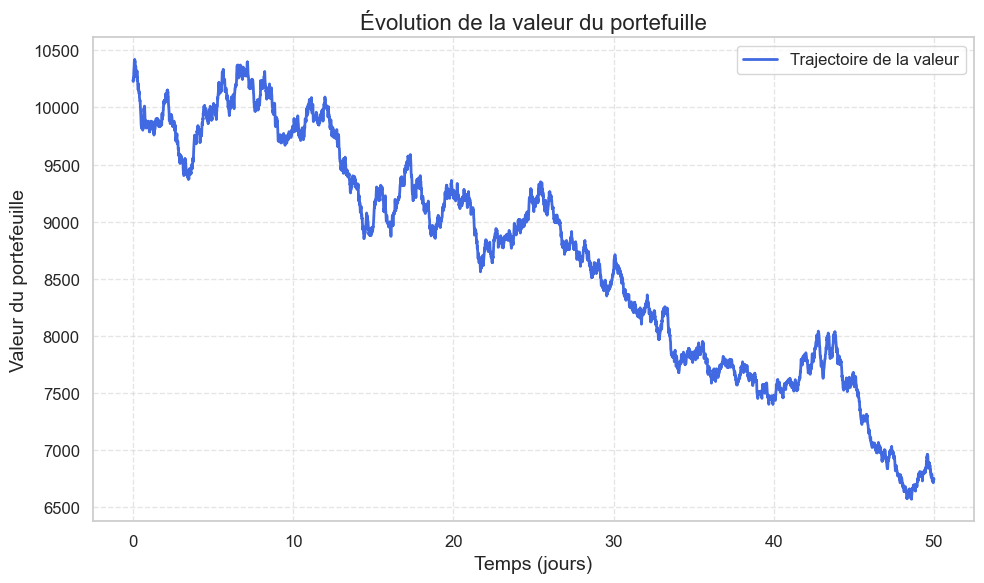

In [10]:
Portfolio=Portfolio_Value(alpha,beta,50,365,S_s,K,vars)[0][0]
time=np.linspace(0,50,5001)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time,Portfolio, color='royalblue', linewidth=2, label='Trajectoire de la valeur')

plt.title("Évolution de la valeur du portefuille", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Valeur du portefeuille", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### 2 – Estimations

On commence tout d'abord par estimerla fonction de répartition du portefuille en utilisant la méthode de Monte Carlo naif

In [11]:
def empirical_cdf(alpha,beta,t,T,S,K,vars,x,h=0.01,n_paths=1000):
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)[0][:,-1]
    result=np.mean(result<=x)
    return result

def empirical_ppf(alpha,beta,t,T,S,K,vars,x,h=0.01,n_paths=1000):
    dx=100
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)[0][:,-1]
    result=(np.mean(result<=x+dx)-np.mean(result<=x))/dx
    return result

#Cette deuxième fonction est beaucoup plus efficace pour des raisons de complexité temporelle
def empirical_cdf_MCMC(Portfolio,x):
    result=Portfolio[:,-1]
    result=np.mean(result<=x)
    return result
    
def empirical_ppf_MCMC(Portfolio,x):
    dx=100
    result=Portfolio[:,-1]
    result=(np.mean(result<=x+dx)-np.mean(result<=x))/dx
    return result

In [12]:
x=10000
F=empirical_cdf(alpha,beta,10,365,S_s,K,vars,x)
print("la fonction de réparttion en "+str(x)," est égale à: "+str(F))
df=empirical_ppf(alpha,beta,10,365,S_s,K,vars,x)
print(df)


la fonction de réparttion en 10000  est égale à: 0.471
0.00040000000000000034


Une deuxième expérience est la calcul de la moyenne de notre portfeuille à tout instant.
Autrement dit, on détermine $(\mathbb{E}(V_t))_{t \geq 0}$ en utilisant la méthode de Monte Carlo naif.

In [13]:
def Portfolio_mean(alpha,beta,t,T,S,K,vars,h=0.1,n_paths=1000):
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)[0]
    result=np.mean(result,axis=0)
    return result
        

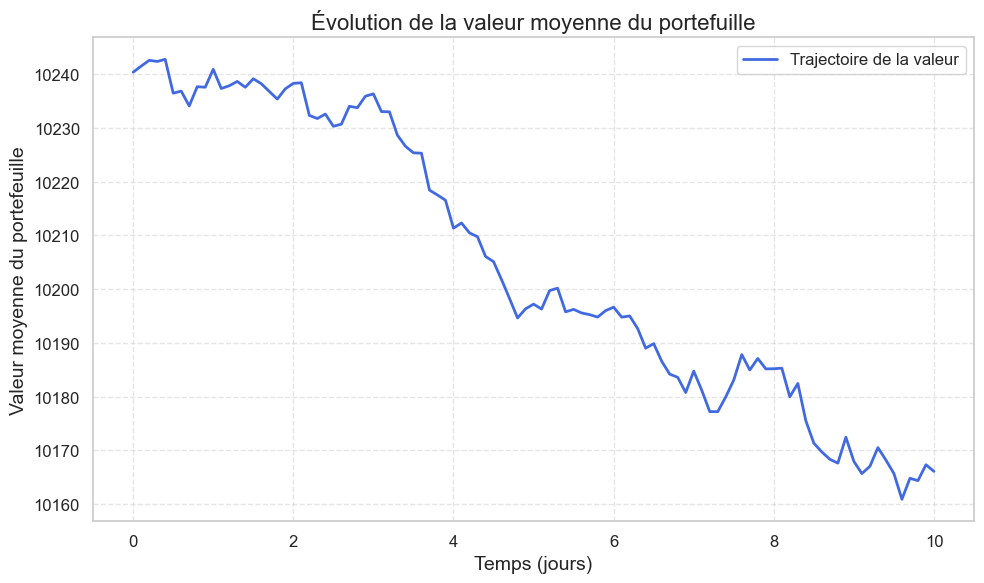

In [14]:
Mean=Portfolio_mean(alpha,beta,10,365,S_s,K,vars)
time=np.linspace(0,10,101)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time,Mean, color='royalblue', linewidth=2, label='Trajectoire de la valeur')

plt.title("Évolution de la valeur moyenne du portefuille", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Valeur moyenne du portefeuille", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Pour montrer la limite de la méthode de Monte Carlo naif, on simule la probabilité que la valeur du portefeuille soit supérieure où égale à une contsante * sa moyenne. $\\$
C'est à dire qu'on estime $\mathbb{P}(V_t \geq bound*\mathbb{E}(V_t))$

In [15]:
def Probability_above_average(alpha,beta,t,T,S,K,vars,bound=1,h=0.1,n_paths=10000):
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)[0]
    result=np.mean(result > bound * Mean, axis=0)
    return result
        

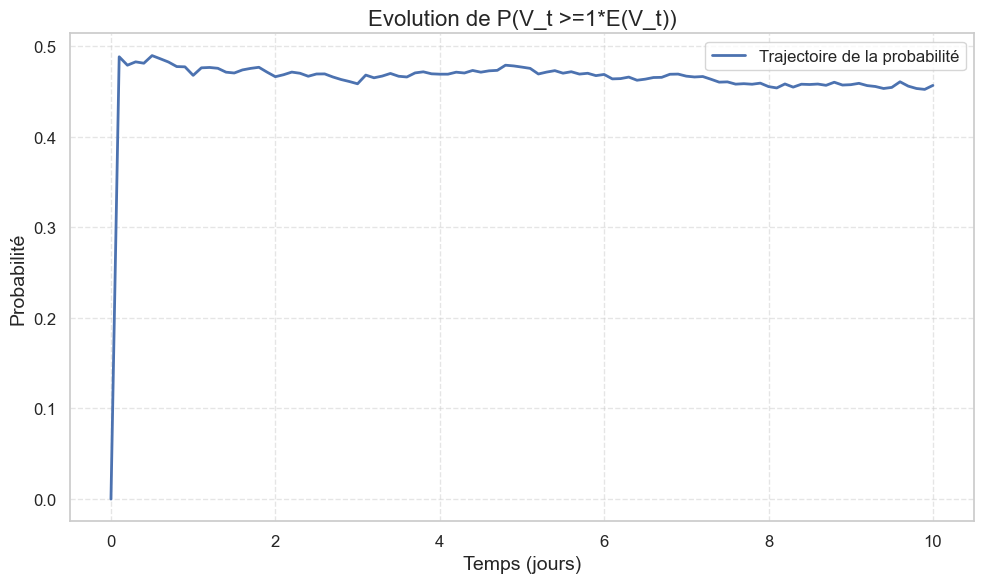

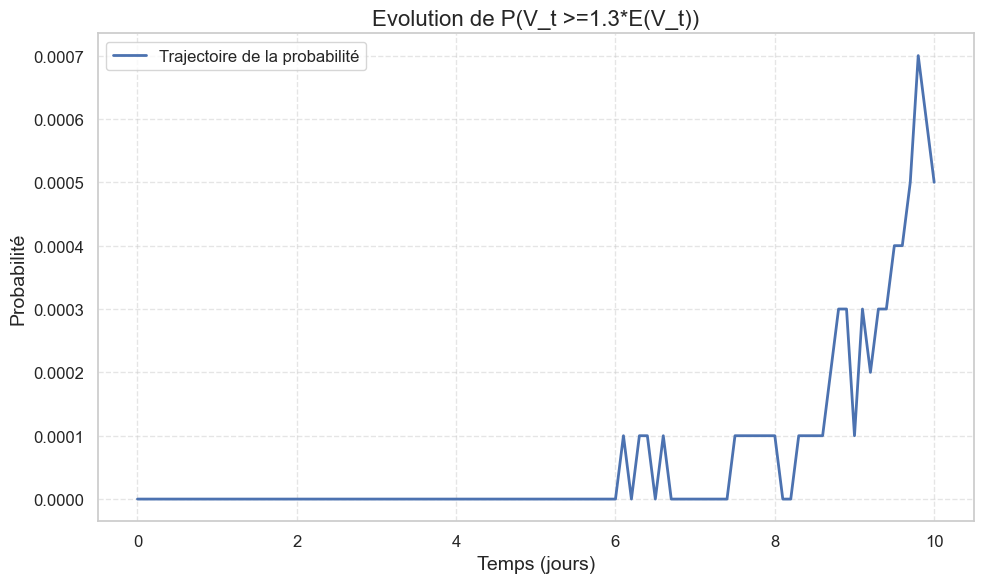

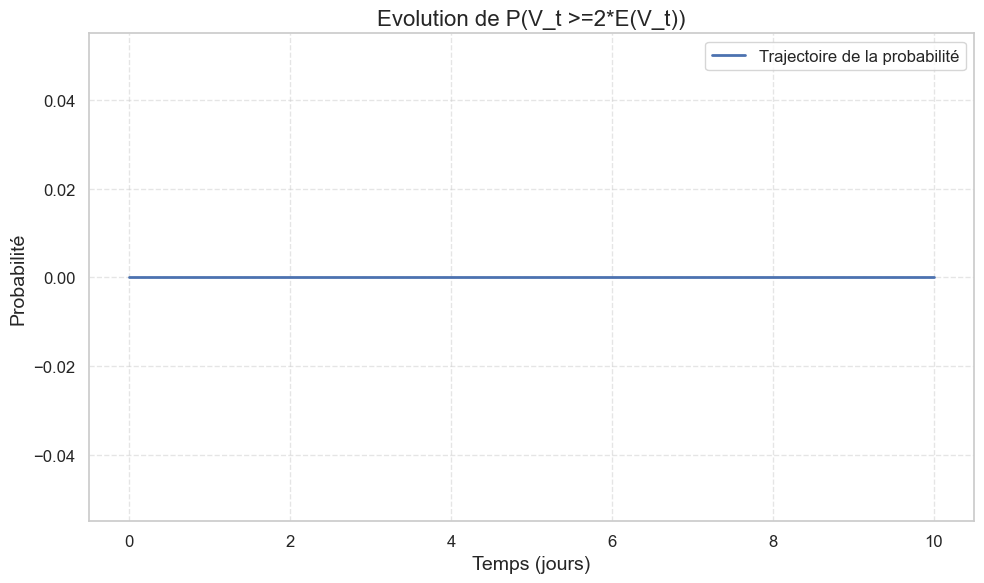

In [33]:
for i in [1,1.3,2]:
    proba=Probability_above_average(alpha,beta,10,365,S_s,K,vars,bound=i)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.plot(time,proba, linewidth=2, label='Trajectoire de la probabilité')

    plt.title("Evolution de P(V_t >={}*E(V_t))".format(i),fontsize=16)
    plt.xlabel("Temps (jours)", fontsize=14)
    plt.ylabel("Probabilité", fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

On remarque que déjà pour bound=1.3 cette méthode a du mal a estimer cette probabilité. Alors que pour bound=2 cet algorithme génère 0 comme estimation de la probabilité vu qu'il s'agit d'un évènement rare.

On estime maintenant la fonction quantile qu'on utilisera pour l'algorithme de MCMC. On utilisera les statistiques d'ordre vus en cours.

In [17]:
def empirical_quantile(alpha,beta,t,T,S,K,vars,seuil=0.1,h=0.1,n_paths=1000):
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)[0]
    result=np.sort(result,axis=0)
    rank=int(np.ceil((1-seuil)*n_paths))
    if rank==n_paths:
        return result[-1]
    return result[rank]

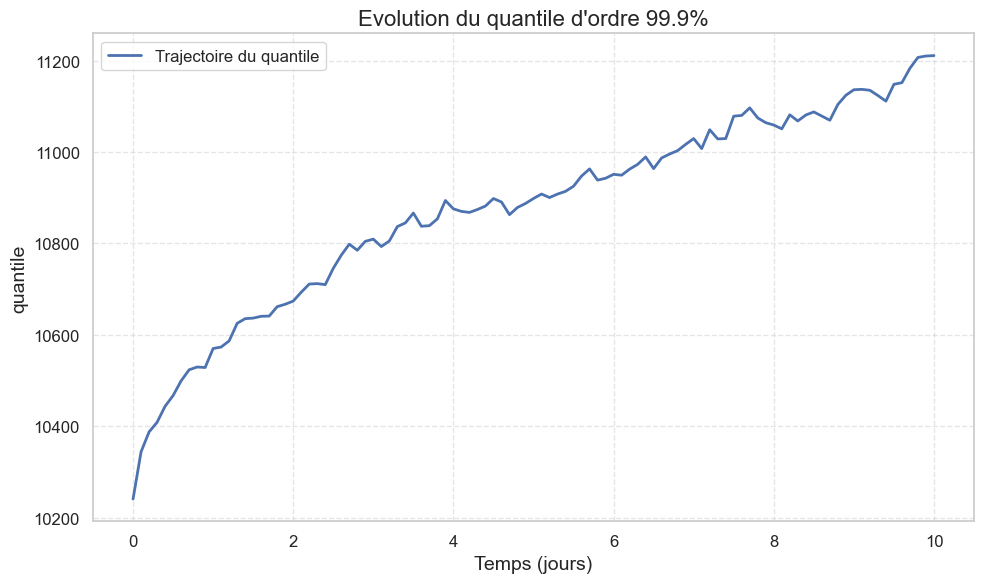

In [18]:
quantiles=empirical_quantile(alpha,beta,10,365,S_s,K,vars,seuil=0.1)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time,quantiles, linewidth=2, label='Trajectoire du quantile')

plt.title("Evolution du quantile d'ordre {}%".format((100*1-0.1)),fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("quantile" , fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
def importance_sampling_quantile(alpha,beta,t,T,S,K,vars,seuil=0.1,h=0.1,n_paths=10000,theta_shift=0.15):
    '''Cette fonction permet d'estima la probabilité que la valeur du portefeuille à l'instant t
    dépasse bound*sa moyenne à cet instant en utilisant la méthode de l'échantillonnage d'importance.'''
    
    n_stocks=len(S)
    n_steps=int(t/h)+1
    time_grid=np.linspace(0,t,n_steps)/365
    result=np.zeros(n_paths)
    likelihood_ratios=np.ones(n_paths)

    for i in range(n_stocks):
        # Simuler un brownien avec drift: W + θt
        dW=np.random.normal(loc=theta_shift*h/365,scale=np.sqrt(h/365),size=(n_paths,n_steps-1))
        W=np.concatenate([np.zeros((n_paths,1)), np.cumsum(dW,axis=1)],axis=1)

        # Stock path with drift
        Stock_paths=S[i]*np.exp((-0.5*vars[i]**2 )*time_grid+vars[i]*W)

        # Calcul des options
        call_paths=Call_price(vars[i],K,T,Stock_paths,h)
        put_paths=Put_price(vars[i],K,T,Stock_paths,h)

        # Mise à jour du portefeuille
        result+=alpha[i]*call_paths[:,-1]+beta[i]*put_paths[:,-1]

        # Mettre à jour les poids de vraisemblance pour chaque stock
        W_T=W[:,-1]
        likelihood_ratios*=np.exp(-theta_shift*W_T-0.5*(theta_shift**2)*t/365)
    sorted_indices = np.argsort(result)
    sorted_result = result[sorted_indices]
    sorted_weights = likelihood_ratios[sorted_indices]
    sorted_weights /= np.sum(sorted_weights)
    weighted_cdf = np.cumsum(sorted_weights)
    quantile_index = np.searchsorted(weighted_cdf, 1 - seuil)
    return sorted_result[quantile_index]
    

In [71]:
importance_sampling_quantile(alpha,beta,10,365,S_s,K,vars,seuil=0.0001,n_paths=100000,theta_shift=0.15)

np.float64(13763.428443820263)

In [70]:
importance_sampling_quantile(alpha,beta,10,365,S_s,K,vars,seuil=0.0000001,n_paths=100000,theta_shift=3)

np.float64(15640.818468183446)

In [72]:
importance_sampling_quantile(alpha,beta,10,365,S_s,K,vars,seuil=0.0000000001,n_paths=100000,theta_shift=10)

np.float64(17689.52881557106)

### 3 - Estimation de Probabilités Rares

Dans cette section, nous estimons la probabilité que la valeur finale du portefeuille dépasse un seuil rare, défini comme un multiple de sa moyenne :
$$\mathbb{P}(V_T > \text{bound} \times \mathbb{E}[V_T])$$

### Problème
Dans le cas où cet événement est rare (par exemple, `bound = 1.3`), comme on l'a vu précédemmt, l'estimation naïve par Monte Carlo nécessite un très grand nombre de trajectoires. Cela rend la méthode inefficace.

### Solution 1 : Splitting
1. **Simulation initiale** :
   On simule $n$ trajectoires du portefeuille à la date $t$, et on calcule la moyenne empirique $\hat{\mu} = \mathbb{E}[V_T]$.

2. **Définition d’un premier niveau** :
   On fixe un premier seuil (niveau) via un quantile empirique (ex: 80e percentile si `seuil=0.2`). Cela permet d’extraire les **trajectoires survivantes**.

3. **Splitting adaptatif** :
   À chaque itération, on :
   - Garde les trajectoires $V_T \geq \text{niveau courant}$,
   - Génère de nouvelles trajectoires par **mutation MCMC** :  
     - 90% de mouvements locaux (loi normale autour d’un survivant),
     - 10% de sauts globaux (loi uniforme contrôlée),
   - Fixe un **nouveau niveau** (quantile suivant),
   - Multiplie la probabilité conditionnelle par le `seuil`.

4. **Arrêt du processus** :
   Le processus s’arrête si :
   - Le niveau dépasse $\text{bound} \times \hat{\mu}$,
   - La progression stagne (niveau quasiment inchangé),
   - Trop de niveaux sont atteints (`max_levels`).

5. **Estimation finale** :
   La probabilité totale est estimée par :
   $$\mathbb{P}(V_T > \text{bound} \times \hat{\mu}) \approx p_1 \cdot p_2 \cdots p_k \cdot \hat{p}_{\text{final}}$$
   où chaque $p_i = \text{seuil}$ est une probabilité conditionnelle entre deux niveaux.



In [21]:
def Probability_above_average_MCMC(alpha,beta,t,T,S,K,vars,seuil=0.1,bound=1,h=0.1,n=1000):
    levels=empirical_quantile(alpha,beta,t,T,S,K,vars,seuil=seuil)
    levels=[[level] for level in levels]
    result=np.array([])
    it=1
    for i in range(len(levels)-1,len(levels)):
    #for i in range(1,len(levels)):
        Portfolio=Portfolio_Value(alpha,beta,i*h,T,S,K,vars,h,n)[0]
        Mean=Portfolio_mean(alpha,beta,i*h,T,S,K,vars)
        print("Level {}: {}".format(it,levels[i][-1]))
        while levels[i][-1]<bound*Mean[-1]:
            it+=1
            starting_point=levels[i][-1]
            X=[starting_point]
            accepted=0
            for _ in range(n):
                proposal_std=15
                if accepted/n<0.2:
                    proposal_std*=0.9
                elif accepted/n>0.5:
                    proposal_std*=1.1
                transition_point=np.random.normal(X[-1],proposal_std)
                cdf_new = empirical_cdf_MCMC(Portfolio, transition_point)
                cdf_old = empirical_cdf_MCMC(Portfolio, X[-1])
                a = min(1, (1 - cdf_new) / (1 - cdf_old + 1e-12))
                u=np.random.random()
                next_point=transition_point*int(u<=a)+X[-1]*int(u>a)
                accepted+=int(u<=a)
                next_point=next_point*int(next_point>=levels[i][-1])+X[-1]*int(next_point<levels[i][-1])
                X.append(next_point)
            X=np.array(sorted(X[int(0.3 * len(X)):]))
            #X=np.array(sorted(X))
            levels[i].append(X[int(np.ceil(len(X)*(1-seuil)))-1])
            print("Level {}: {}".format(it,levels[i][-1]))
            print("The biggest Markov chain value: {}".format(X[-1]))
        last_term=np.mean(X>bound*Mean[-1])
        result=np.append(result,last_term*seuil**(len(levels[i])-1))
    return result

In [22]:
Probability_above_average_MCMC(alpha,beta,10,365,S_s,K,vars,seuil=0.2,bound=1.3,n=100000)

Level 1: 10748.899729741112
Level 2: 11452.171064483551
The biggest Markov chain value: 12772.782713153932
Level 3: 12084.956982580323
The biggest Markov chain value: 13246.817571286014
Level 4: 12611.104646720612
The biggest Markov chain value: 13325.28590933828
Level 5: 13184.408301354832
The biggest Markov chain value: 15363.473619955223


array([0.00048907])

In [35]:
Probability_above_average_MCMC(alpha,beta,10,365,S_s,K,vars,seuil=0.2,bound=1.5,n=10000)

Target = 1.50 * mean = 15149.0544
Level 1: 10728.9818
Level 2: 11552.5261
Level 3: 12249.6372
Level 4: 12814.0543
Level 5: 13409.6967
Level 6: 14296.4594
Pas d'amélioration du niveau. Stop.
Estimation finale: P(V_T > 1.5 * mean) ≈ 0.000000e+00


(np.float64(0.0), np.float64(0.0), np.float64(0.0))

In [23]:
def Probability_above_average_MCMC(alpha, beta, t, T, S, K, vars, seuil=0.2, rho=0.99, bound=1.4, h=0.1, n=10000, max_levels=100):
    '''Estime P(V_T > bound * E[V_T]) via splitting (MCMC).'''

    # Étape 1: simulation initiale
    Portfolio, Brownian_mo = Portfolio_Value(alpha, beta, t, T, S, K, vars, h, n)
    Values = Portfolio[:, -1]
    Mean = np.mean(Values)
    print(f"Target = {bound:.2f} * mean = {bound * Mean:.4f}")
    
    # Étape 2: premier niveau
    level = empirical_quantile(alpha, beta, t, T, S, K, vars, seuil=seuil)[-1]
    levels = [level]
    prob = 1.0
    iteration = 0
    ci_lower,ci_upper=1,1
    
    while level < bound * Mean:
        iteration += 1
        print(f"Level {iteration}: {level:.4f}")

        # Sélection des survivants
        survivors = Values[Values >= level]
        Brownian_survivors = Brownian_mo[Values >= level]
        n_survivors = len(survivors)

        if n_survivors == 0:
            print("Aucun survivant. Probabilité ≈ 0.")
            return 0.0

        # S'il n'y a pas eu de sélection stricte (tout le monde survit), on avance manuellement
        if n_survivors == n:
            print("Tous les échantillons ont survécu. Avancement manuel du niveau.")
            level += 0.01 * Mean  # petite augmentation artificielle
            prob *= 1.0  # pas de réduction du seuil ici
            continue
        
        prob_level=n_survivors/n
        std_error=np.std(Values>=level,ddof=1)/np.sqrt(n)
        z_95=sps.norm.ppf(0.975)
        ci_lower*=(prob_level-z_95*std_error)
        ci_upper*=(prob_level+z_95*std_error)

        # Génération de nouvelles propositions par MCMC
        new_samples = list(survivors)
        for _ in range(n - n_survivors):
            i = np.random.randint(n_survivors)
            modified_bro,modified_bro_1 = Brownian_survivors[i].copy(),Brownian_survivors[i].copy()
            prochain=0
            for _ in range(20):
                Y = np.random.normal(loc=0, scale=np.sqrt(t / 365), size=modified_bro.shape)
                modified_bro_1 = rho * modified_bro_1 + np.sqrt(1 - rho**2) * Y
                pv = Portfolio_Value_MCMC(modified_bro_1, alpha, beta, t, T, S, K, vars)
                if pv>=level:
                    prochain=pv
                    modified_bro=modified_bro_1
            Brownian_mo[i]=modified_bro
            if prochain==0:
                prochain=survivors[i]
            new_samples.append(prochain)

        Values = np.array(new_samples)
        new_level = np.quantile(Values, 1 - seuil)

        # Sécurité : éviter d’avoir un nouveau niveau inférieur à l’ancien
        if new_level <= level:
            print("Pas d'amélioration du niveau. Stop.")
            break

        level = new_level
        levels.append(level)
        prob *= prob_level
        
        if iteration >= max_levels:
            print("Nombre max de niveaux atteint. Stop.")
            break
        

    # Estimation finale
    final_prob = np.mean(Values > bound * Mean)
    std_error=np.std(Values>=level,ddof=1)/np.sqrt(n)
    z_95=sps.norm.ppf(0.975)
    ci_lower*=(final_prob-z_95*std_error)
    ci_upper*=(final_prob+z_95*std_error)
    total_prob = prob * final_prob
    print(f"Estimation finale: P(V_T > {bound} * mean) ≈ {total_prob:.6e}")
    return total_prob , ci_lower , ci_upper

In [44]:
estimate , inf,sup= Probability_above_average_MCMC(alpha,beta,10,365,S_s,K,vars,rho=0.8,seuil=0.1,bound=1.3,n=10000)
print(estimate)
print("intervalle de confiance:[{},{}]".format(inf,sup))
print((sup-estimate)/estimate)


Target = 1.30 * mean = 13146.8880
Level 1: 11221.9380
Level 2: 12262.4700
Level 3: 13072.9199
Estimation finale: P(V_T > 1.3 * mean) ≈ 6.629741e-04
0.0006629741456520002
intervalle de confiance:[0.0005444424147823572,0.0007985410136136077]
0.2044828879839418


In [46]:
estimate , inf,sup= Probability_above_average_MCMC(alpha,beta,10,365,S_s,K,vars,rho=0.8,seuil=0.1,bound=1.4,n=50000)
print(estimate)
print("intervalle de confiance:[{},{}]".format(inf,sup))
print((sup-estimate)/estimate)

Target = 1.40 * mean = 14142.4901
Level 1: 11096.3879
Level 2: 12120.2664
Level 3: 12908.7562
Level 4: 13724.3184
Estimation finale: P(V_T > 1.4 * mean) ≈ 3.264114e-05
3.2641141199163515e-05
intervalle de confiance:[2.8991488995006627e-05,3.664530743632655e-05]
0.1226723726579036


On remarque que cet algorithme arrive à capter d'une façon plus bonne les évènements de probabilités de l'ordre de $10^4$ mais il échoue à capter les cas extrèmes. Ceci est du au fait qu'on utilise une estimation de la densité donc on a du mal à atteindre la queue de la distribution

### Solution 2 : Importance Sampling
Nous modifions la loi de simulation des trajectoires pour rendre l'événement rare plus probable, puis nous corrigeons ce biais via un facteur de vraisemblance.

#### Étapes de l'algorithme :
1. **Simulation biaisée** :  
   On simule chaque mouvement brownien avec un drift artificiel $\theta$, i.e.  
   $W_t^\theta = W_t + \theta t$
   Ce drift rend les grandes valeurs du portefeuille plus probables.

2. **Évaluation du portefeuille** :  
   Pour chaque trajectoire, on calcule la valeur finale du portefeuille en utilisant les fonctions de prix des options (`Call_price`, `Put_price`).

3. **Correction de la probabilité** :  
   Pour chaque trajectoire, on applique un poids de vraisemblance (likelihood ratio) correspondant au changement de mesure :
   $L = \exp\left(-\theta W_T - \frac{1}{2} \theta^2 T\right)$

4. **Estimation finale** :  
   La probabilité recherchée est estimée comme :
   $$\hat{p} = \frac{1}{N} \sum_{i=1}^N \mathbf{1}_{\{V_T^{(i)} > \text{bound} \times \hat{\mu}\}} \cdot L^{(i)}$$
   où $\hat{\mu}$ est la moyenne empirique des $V_T$ sous importance sampling.

In [25]:
def importance_sampling_probability(alpha,beta,t,T,S,K,vars,bound=1,h=0.1,n_paths=10000,theta_shift=0.15):
    '''Cette fonction permet d'estima la probabilité que la valeur du portefeuille à l'instant t
    dépasse bound*sa moyenne à cet instant en utilisant la méthode de l'échantillonnage d'importance.'''
    
    n_stocks=len(S)
    n_steps=int(t/h)+1
    time_grid=np.linspace(0,t,n_steps)/365

    # Moyenne de référence
    mean_portfolio=Portfolio_mean(alpha,beta,t,T,S,K,vars,h,n_paths)[-1]

    result=np.zeros(n_paths)
    likelihood_ratios=np.ones(n_paths)

    for i in range(n_stocks):
        # Simuler un brownien avec drift: W + θt
        dW=np.random.normal(loc=theta_shift*h/365,scale=np.sqrt(h/365),size=(n_paths,n_steps-1))
        W=np.concatenate([np.zeros((n_paths,1)), np.cumsum(dW,axis=1)],axis=1)

        # Stock path with drift
        Stock_paths=S[i]*np.exp((-0.5*vars[i]**2 )*time_grid+vars[i]*W)

        # Calcul des options
        call_paths=Call_price(vars[i],K,T,Stock_paths,h)
        put_paths=Put_price(vars[i],K,T,Stock_paths,h)

        # Mise à jour du portefeuille
        result+=alpha[i]*call_paths[:,-1]+beta[i]*put_paths[:,-1]

        # Mettre à jour les poids de vraisemblance pour chaque stock
        W_T=W[:,-1]
        likelihood_ratios*=np.exp(-theta_shift*W_T-0.5*(theta_shift**2)*t/365)
    indicator=(result>bound*mean_portfolio)
    weighted_samples=indicator*likelihood_ratios
    # Estimation finale
    estimate=np.mean(weighted_samples)
    
    # Intervalle de confiance 
    std_error=np.std(weighted_samples,ddof=1)/np.sqrt(n_paths)
    z_95=sps.norm.ppf(0.975)
    ci_lower=estimate-z_95*std_error
    ci_upper=estimate+z_95*std_error

    return estimate, (max(0,ci_lower),ci_upper)

In [47]:
importance_sampling_probability(alpha,beta,10,365,S_s,K,vars,bound=1.3,n_paths=100000,theta_shift=0.2)

(np.float64(0.0006280913761028316),
 (np.float64(0.0004982356465624538), np.float64(0.0007579471056432094)))

In [48]:
importance_sampling_probability(alpha,beta,10,365,S_s,K,vars,bound=1.4,n_paths=100000,theta_shift=2)

(np.float64(7.122356498997118e-06),
 (np.float64(5.703658474203641e-06), np.float64(8.541054523790595e-06)))

In [78]:
importance_sampling_probability(alpha,beta,10,365,S_s,K,vars,bound=1.4,n_paths=100000,theta_shift=2)

(np.float64(7.047851280155916e-06),
 (np.float64(5.546606220457674e-06), np.float64(8.549096339854159e-06)))

In [80]:
importance_sampling_probability(alpha,beta,10,365,S_s,K,vars,bound=1.5,n_paths=100000,theta_shift=2.5)

(np.float64(1.6337973218914376e-07),
 (np.float64(7.474659888737689e-08), np.float64(2.520128654909106e-07)))

In [83]:
importance_sampling_probability(alpha,beta,10,365,S_s,K,vars,bound=1.7,n_paths=100000,theta_shift=3)

(np.float64(2.218342100292048e-10), (0, np.float64(6.566212722253403e-10)))